In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import segyio
from scipy.interpolate import griddata

In [2]:
def read_seismic_cube(file_path):
    """
    :param file_path: Путь к файлу
    :return: возвращает куб в виде списков по Inlines, Xlines и Sampels (координаты x, y, z)
    а также словарю сейсмотрасс, где ключ это координата пересечения Inlines и Xlines, а значение это список значений сейсмотрасс
    """
    with segyio.open(file_path, 'r') as segyfile:
        x = list(segyfile.ilines)
        y = list(segyfile.xlines)
        z = list(segyfile.samples)
        cube = segyio.tools.cube(segyfile)
        traces = {f"{x[i]}_{y[j]}": cube[i][j][:] for i in range(len(x)) for j in range(len(y))}
    return x, y, z, traces

In [3]:
def mean_of_abs(list_value):
    """
    считает среднее по модулю значение сейсмотрассы
    :param list_value: сейсмотрасса
    :return: среднее значение
    """
    abs_value = [abs(v) for v in list_value]
    mean_value = sum(abs_value) / len(abs_value)
    return mean_value

In [4]:
def point_in_polygon(point, polygon):
    """
    Проверяет находится ли точка в полигоне (внутри краевой зоны) 
    :param point: точка с координатами (пересечение инлайнов и крослайнов)
    :param polygon: краевая зона в виде полигона
    :return: 1 если точка внутри полигона, 0 иначе
    """
    # Преобразование строки координат точки в кортеж чисел
    point = tuple(map(int, point.split('_')))
    # Преобразование списка строк координат полигона в список кортежей чисел
    polygon = [tuple(map(int, coord.split('_'))) for coord in polygon]
    # Создание объекта Path из координат полигона
    path = Path(polygon)
    # Проверка принадлежности точки полигону
    return 1 if path.contains_point(point) else 0

In [5]:
def show_map(data_dict):
    # Преобразование словаря в списки координат и значений
    coordinates = [tuple(map(int, key.split('_'))) for key in data_dict.keys()]
    values = list(data_dict.values())

    # Разделение координат на списки x и y
    x_coords, y_coords = zip(*coordinates)

    # Создание сетки для интерполяции значений
    grid_x, grid_y = np.mgrid[min(x_coords):max(x_coords):100j, min(y_coords):max(y_coords):100j]

    # Интерполяция значений для создания тепловой карты
    grid_z = griddata(coordinates, values, (grid_x, grid_y), method='cubic')

    # Отображение тепловой карты
    plt.imshow(grid_z.T, extent=(min(x_coords), max(x_coords), min(y_coords), max(y_coords)), origin='lower')
    plt.scatter(x_coords, y_coords, c=values)  # Отображение исходных точек
    plt.colorbar()  # Добавление шкалы цвета

    #points = ['700_450', '800_475', '725_475', '780_565']
    points = []
    for point in points:
        x, y = key_to_coords(point)
        plt.scatter(y - 1, x - 1, color='red', s=20)

    plt.show()

In [6]:
def key_to_coords(key):
    x, y = key.split("_")
    return int(x), int(y)

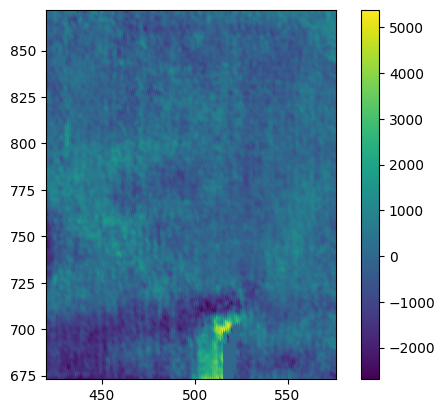

In [7]:
#file_path = 'C:/HV/Seismic/1.1_edge_zone/Cube_TWT.segy'
file_path = 'C:/HV/Seismic/datas/Geobody_cube.segy'
ilines, xlines, samples, traces = read_seismic_cube(file_path)

map_amplitude = {}
for key in traces:
    #if point_in_polygon(key, edge_zona) == 1:
    #map_amplitude[key] = mean_of_abs(traces[key][10])
    map_amplitude[key] = traces[key][-3]
show_map(map_amplitude)

In [8]:
def show_map_2(data_dict):
    # Преобразование словаря в списки координат и значений
    coordinates = [tuple(map(int, key.split('_'))) for key in data_dict.keys()]
    values = list(data_dict.values())

    # Разделение координат на списки x и y
    x_coords, y_coords = zip(*coordinates)

    # Создание сетки для интерполяции значений
    grid_x, grid_y = np.mgrid[min(x_coords):max(x_coords):100j, min(y_coords):max(y_coords):100j]

    # Интерполяция значений для создания тепловой карты
    grid_z = griddata(coordinates, values, (grid_x, grid_y), method='cubic')

    # Подписи осей
    plt.xlabel('Inlines')
    plt.ylabel('Xlines')

    # Отображение тепловой карты
    plt.imshow(grid_z.T, extent=(min(x_coords), max(x_coords), min(y_coords), max(y_coords)), origin='lower')
    plt.scatter(x_coords, y_coords, c=values)  # Отображение исходных точек
    plt.colorbar()  # Добавление шкалы цвета

    #points = ['700_450', '800_475', '725_475', '780_565']
    points = []
    for point in points:
        x, y = key_to_coords(point)
        plt.scatter(y - 1, x - 1, color='red', s=20)

    plt.show()

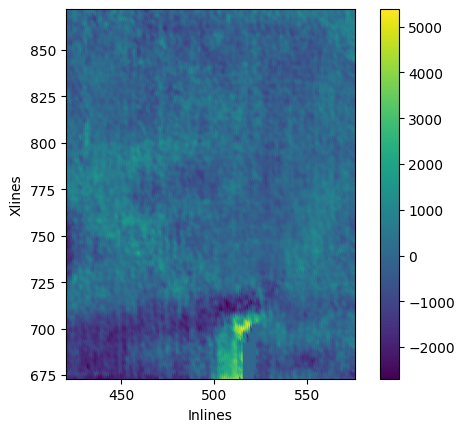

In [9]:
show_map_2(map_amplitude)

In [11]:
def loc_max(values):
    """
    Функция ищет выбросы (локальные максимумы) с помощью скользящего интервала
    :param values: список линии  по Inlines или Xlines
    :return:
    """

    local_max = []
    for i in range(0, len(values) - 10 + 1, 3):
        # Выбираем текущий интервал
        current_interval = values[i:i + 10]
        # Находим максимум в текущем интервале
        max_value = max(current_interval)
        # Если максимум не равен 0, находим его индекс
        if max_value != 0:
            max_index = i + current_interval.index(max_value)
            # Проверяем, есть ли уже такой индекс в списке local_max
            if not any(max_index == existing_index for _, existing_index in local_max):
                local_max.append((max_value, max_index))
    return local_max

In [12]:
def plot_coordinate(data_dict, coord_string):
    parts = coord_string.split('=')
    axis = parts[0].strip().lower()
    value = int(parts[1].strip())
    #print(parts, axis, value)
    x_values = []
    y_values = []
    values = []

    for key in data_dict:
        coords = key.split('_')
        x = int(coords[0][0:])  # Преобразуем в стандартный тип int
        y = int(coords[1][0:])  # Преобразуем в стандартный тип int
        #print(key, x, y)
        if axis == 'x' and x == int(value):
            x_values.append(y)
            values.append(data_dict[key])
        if axis == 'y' and y == int(value):
            x_values.append(x)
            values.append(data_dict[key])

    return values

In [13]:
values_on_lines = plot_coordinate(map_amplitude, 'y=750')
print(loc_max(values_on_lines))

[(345.18274, 7), (345.18274, 14), (966.5117, 24), (1242.658, 27), (1104.5848, 31), (1104.5848, 38), (1449.7676, 45), (966.5117, 49), (759.40204, 56), (345.18274, 57), (138.07307, 65), (-2.2977942e-05, 66), (483.25583, 78), (-2.2977942e-05, 81), (-2.2977942e-05, 84), (-2.2977942e-05, 88), (-2.2977942e-05, 92), (-2.2977942e-05, 100), (-2.2977942e-05, 104), (-138.07312, 105), (-138.07312, 108), (138.07307, 119), (345.18274, 122), (621.3289, 132), (966.5117, 135), (966.5117, 138), (483.25583, 145), (345.18274, 148)]


In [14]:
def futprint_i(map):
    delta_t = 0
    delta_value = 0
    chet_vershin = 0
    futprint_ilines = []
    for i in range(len(ilines)):
        values_lines = loc_max(plot_coordinate(map, 'x=' + str(ilines[i])))
        if len(values_lines) != 0:
            delta_t = values_lines[1][1] - values_lines[0][1]
            delta_value = values_lines[0][0]
            for j in range(len(values_lines) - 1):
                if (delta_t * 0.9) <= (values_lines[j + 1][1] - values_lines[j][1]) <= (delta_t * 1.1):
                    if (delta_value * 0.9) <= values_lines[j][0] <= (delta_value * 1.1):
                        chet_vershin += 1
                    else:
                        chet_vershin = 0
                        continue
                else:
                    chet_vershin = 0
                if chet_vershin == 5:
                    for k in range(5):
                        futprint_ilines.append(str(ilines[i]) + '_' + str(xlines[values_lines[j - k][1]]))
        else:
            continue

    return futprint_ilines

In [ ]:
f_i = []
for l in range(len(samples)):
    for key in traces:
        map_amplitude[key] = traces[key][l]
    f_i.append(futprint_i(map_amplitude))
print(f_i)

In [ ]:
def futprint_x(map):
    delta_t = 0
    delta_value = 0
    chet_vershin = 0
    futprint_xlines = []
    for i in range(len(xlines)):
        values_lines = loc_max(plot_coordinate(map, 'y=' + str(xlines[i])))
        if len(values_lines) != 0:
            delta_t = values_lines[1][1] - values_lines[0][1]
            delta_value = values_lines[0][0]
            #print(len(values_lines))
            for j in range(len(values_lines) - 1):
                if (delta_t * 0.9) <= (values_lines[j + 1][1] - values_lines[j][1]) <= (delta_t * 1.1):
                    if (delta_value * 0.9) <= values_lines[j][0] <= (delta_value * 1.1):
                        chet_vershin += 1
                    else:
                        chet_vershin = 0
                        continue
                else:
                    chet_vershin = 0
                if chet_vershin == 5:
                    for k in range(5):
                        futprint_xlines.append(str(ilines[values_lines[j - k][1]]) + '_' + str(xlines[i]))
        else:
            continue

    return futprint_xlines

In [ ]:
f_x = []
for l in range(len(samples)):
    for key in traces:
        map_amplitude[key] = traces[key][l]
    f_x.append(futprint_x(map_amplitude))
print(f_x)

In [ ]:
# Создание массивов координат и значений для построения карты
coords = [key_to_coords(key) for key in map_amplitude.keys()]
values = list(map_amplitude.values())

# Создание массивов координат для нанесения точек
points_coords = []
for sublist in f_x:
    for point in sublist:
        points_coords.append(key_to_coords(point))

# Разделение координат на X и Y
x_coords, y_coords = zip(*coords)
x_points, y_points = zip(*points_coords) if f_x else ([], [])

# Создание графика
plt.figure(figsize=(8, 8))

# Построение карты
plt.scatter(x_coords, y_coords, c=values, cmap='viridis', s=200)

# Нанесение точек
plt.scatter(x_points, y_points, c='red', s=50)

# Настройка осей
plt.xlim(min(x_coords) - 1, max(x_coords) + 1)
plt.ylim(min(y_coords) - 1, max(y_coords) + 1)
plt.gca().set_aspect('equal', adjustable='box')

# Показ графика
plt.show()
